## Introduction

Hybrid quantum-classical (HQC) algorithms aim at realizing quantum advantage in shallow depth quantum circuits with the aid of classical computation. Quantum gate fidelities directly limit the sizes of executable problems in quantum computers without quantum error correction. 

Our primal goal here is to prepare quantum state as close to target state as possible. It have been mostly studied in the context of quantum optimal control, where gate fidelities are improved with optimally shaped control pulses derived from numerical simulations on a classical computer or actual measurements on the quantum devices under test.

## Methods

The method we are going to present here is published by the [paper](https://arxiv.org/pdf/1806.07366.pdf) of Chen, Rubanova, Bettencourt and Duvenaud. Neural ODE in general is the continuous limit of recurrent neural network. The flow of gradient of parameters can pass through the ODE. As the law of physics is intrinsically continuous, it is natural to apply this method to physical problem.

As a start to demonstrate this method, we take open-loop optimization as an example.

The autograd package `jax` is used here for the autograd framework and adjoint method implementation.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import jax
from jax import jit, vmap, grad
from jax import random
import numpy as np
import jax.numpy as jnp
from jax import vjp

from jax.experimental import ode, optimizers
from jax.experimental.ode import odeint

from jax.config import config  # Force Jax use float64 as default Float dtype
config.update("jax_enable_x64", True)

key = random.PRNGKey(42)

Firstly, we are interested in the gate optimization problem. In superconducting qubit system, remarkablely transmons, ideal Hamiltonian has a simple form.

$$ H(t) = H_0 + H_c,\ H_0=\omega \sigma_z,\ H_c = A(t)\sigma_x $$

$\omega$ is the secular frequency of the superconducting qubit. We parameterize the control field in functional space and expand it with first $\mathrm{N}1$ components of Fourier series. By doing this, the control field is infinite derivativable and smooth in time.

$$ A(t) = \sum_i^{\mathrm{N}1} a_i \sin (i \omega t)$$

In [2]:
@jit
def A(t,p,t1):
    '''
    Control field, 
    '''
    w = jnp.pi/t1
    N1, = jnp.shape(p)
    ft = jnp.array([jnp.sin(w*(i+1)*t) for i in range(N1)])
    return p@ft

The loss is authentically the infidelity between final gate and target gate

$$ \mathcal{L}(p) = 1- |\mathrm{Tr}\left({U(T)^\dagger U_F}\right)/D|^2$$

$D$ is the dimension of unitary gate.

In [3]:
@jit
def loss(t1,flat_p, omega, U_T):
    '''
    define the loss function, which is a pure function
    '''
    sz = jnp.array([[1,0],[0,-1]],dtype=jnp.float32)
    
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix

    def func(y, t, *args):
        t1, omega, flat_p, = args

        return -1.0j*( omega* sz + A(t,flat_p,t1) * sx )@y
        # return -1.0j*( omega* sz)@y

    res = odeint(func, U_0, t_set, t1, omega, flat_p, rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)

With encapsulated method of `_odeint.defvjp()` as the implementation of adjoint method, the gradient can automatically pass through the loss function. 

In [4]:
def GateOptimize(U_F, omega, t1, init_param, num_step=200, learning_rate=1.0):
    '''
    Get the best possible parameter
    psi_i: initial wave function
    psi_f: final wave function
    init_param: initial parameters
    '''
    opt_init, opt_update, get_params = optimizers.adam(
        learning_rate)  # Use adam optimizer
    loss_list = []

    def step_fun(step, opt_state, U_F):
        aug_params = get_params(opt_state)
        t1, flat_params = aug_params
        value, grads = jax.value_and_grad(
            loss, (0, 1))(t1, flat_params, omega, U_F) # use jax autograd
        
        g_t, g_p = grads
        aug_grad = (g_t,g_p)
        opt_state = opt_update(step, aug_grad, opt_state)
        return value, opt_state

    aug_params = (t1,init_param)
    opt_state = opt_init(aug_params)

    # optimize
    for step in range(num_step):
        value, opt_state = step_fun(step, opt_state, U_F)
        loss_list.append(value)
        print('step {0} : loss is {1}'.format(
            step, value), end="\r", flush=True)

    print('final loss = ', value, flush=True)
    return loss_list, get_params(opt_state)

## Results

We take first $10$ Fourier series as an initial demonstration. And our target gate is Pauli-X gate $\sigma_x$.

In [5]:
sx= jnp.array([[0,1],[1,0]],dtype=jnp.float32)

#initial guess
omega0 = 1.
N1 = 10
p = random.normal(key,shape=(N1,)) # Normal initialization
t1 = 1. 

loss_list,(t_f,p_f)=GateOptimize(sx,omega0, t1, p, num_step=200, learning_rate=1.2)

final loss =  8.8487969215138e-088e-08-07


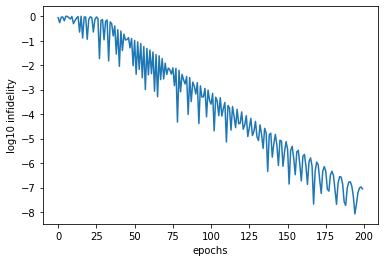

In [6]:
plt.plot(range(len(loss_list)),jnp.log10(jnp.array(loss_list)))
plt.xlabel('epochs')
plt.ylabel('log10 infidelity')

plt.show()

Now that we can view the control field

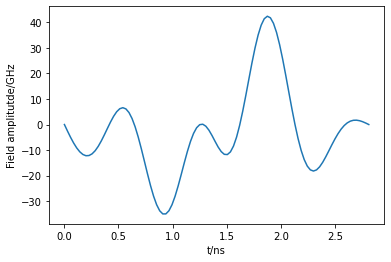

In [7]:
plt.plot(jnp.linspace(0,t_f,100),vmap(A,in_axes=(0,None,None),out_axes=0)(jnp.linspace(0,t_f,100),p_f,t_f))
plt.xlabel('t/ns')
plt.ylabel('Field amplitutde/GHz')

plt.show()

It's continuous function of time and $A(0)=A(t_f)=0$ as required.

## Hessian Based method

The ideal open-loop optimization results can be inappropriate when applying to noisy, shifting systems. To those small deviations from the model, there is a efficient method to obtain reasonable control field without knowing the details of the noise. At the minimum point of infidelity, the gradient is vanished so that the infidelity can be expand by Hessian matirx.

$$\mathcal{L}(\vec{p}) = \mathcal{L_0}+p^T H_p p$$

$\vec{p}$ is the parameter vector and $H_p = \partial^2_p \mathcal{L}$ is the Hessian matrix. Since our infidelity is a scalar function, we can calculate the Jacobian $(\partial_0 \mathcal{L},\partial_1 \mathcal{L},\cdots,\partial_N \mathcal{L})$ with one call of reverse ODE solver. And another call to get the Hessian matrix. It is more efficient comparing to the forward mode, which need $N$ calls to get the Jacobian, and $N^2$ calls for Hessian matrix.

In [8]:
from jax import jacrev
loss_p = lambda p: loss(t_f, p,omega0,sx)
Hess = jacrev(jacrev(loss_p))(p_f)
w, v = jnp.linalg.eig(Hess)
print(w)
arglist = jnp.argsort(w)[-3:]
main_eigen = w[arglist]
main_vec = v[:, arglist]

[ 7.14780858e+00+0.j  3.00185474e-01+0.j  1.16842730e-01+0.j
 -8.96774408e-06+0.j  3.58645829e-06+0.j  1.67469777e-06+0.j
  9.41108950e-07+0.j  7.28230467e-07+0.j -9.59239242e-08+0.j
  2.54910875e-07+0.j]


There are only $3$ main eigenvalues. In general, for $n$ qubits, there will be at most $(2^{2n} - 1)$ linearly independent main eigenvectors.

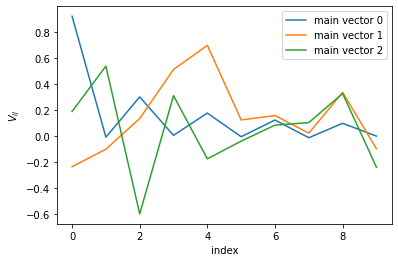

In [9]:
for i in range(10):
    if i in arglist:
        plt.plot(range(10), v.real[:,i],label=f"main vector {i}")

plt.xlabel("index")
plt.ylabel("$V_{ij}$")

plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
plt.show()

In principle, we can tune three parameters to get best optimized control field for small deviation from our ideal Hamiltonian. As an example, we assume that the frequency of qubit deviate a small amount from our expectation (e.g. $\delta \omega /\omega = 0.03$). 

$$ H = H_0(p) + \delta \omega \sigma_z $$

Our result shows that three parameters are sufficient to fix the problem with black box optimization.

In [14]:
@jit
def loss_raw(dp, t1, p0, omega, U_T):
    '''
    define the loss function of 
    Raw method (To optimize all parameters)
    , which is a pure function
    '''
    t_set = jnp.linspace(0., t1, 5)
    sz = jnp.array([[1,0],[0,-1]],dtype=jnp.float32)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D, dtype=jnp.complex128)
    flat_p = p0 + dp

    def func(y, t, *args):
        t1, omega, flat_p, = args

        return -1.0j*(omega * sz + A(t, flat_p, t1) * sx)@y
        # return -1.0j*( omega* sz)@y

    res = odeint(func, U_0, t_set, t1, omega,
                 flat_p, rtol=1.4e-10, atol=1.4e-10)

    U_F = res[-1, :, :]
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)


@jit
def loss_vec(dp, main_vec, t1, p0, omega, U_T):
    '''
    define the loss function of 
    main eigen method (To search in main eigenvector subspace)
    , which is a pure function
    '''
    t_set = jnp.linspace(0., t1, 5)
    sz = jnp.array([[1,0],[0,-1]],dtype=jnp.float32)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D, dtype=jnp.complex128)

    flat_p = p0 + main_vec@dp

    def func(y, t, *args):
        t1, omega, flat_p, = args

        return -1.0j*(omega * sz + A(t, flat_p, t1) * sx)@y
        # return -1.0j*( omega* sz)@y

    res = odeint(func, U_0, t_set, t1, omega,
                 flat_p, rtol=1.4e-10, atol=1.4e-10)

    U_F = res[-1, :, :]
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)

In [15]:
from scipy.optimize import minimize

dw = 0.03
res_vec = minimize(loss_vec,jnp.zeros(3,dtype=jnp.float32),
    args=(main_vec,t_f,p_f,omega0+dw,sx),
                   method='Nelder-Mead',options={'return_all':True}) # Intermediate state results are stored in res_vec.allvecs

res_raw = minimize(loss_raw, jnp.zeros(10, dtype=jnp.float32),
    args=(t_f, p_f, omega0+dw, sx), 
                   method='Nelder-Mead',options={'return_all':True})


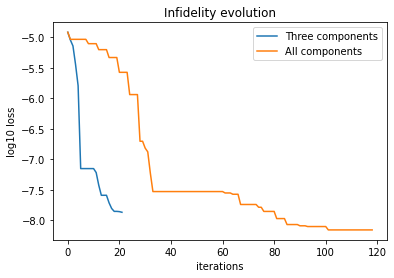

In [16]:
log10_loss_list = [jnp.log10(loss_vec(x,main_vec,t_f,p_f,omega0+dw,sx)) for x in res_vec.allvecs]
log10_loss_list_raw = [jnp.log10(loss_raw(x,t_f,p_f,omega0+dw,sx)) for x in res_raw.allvecs]

plt.plot(np.array(range(res_vec.nit)) , log10_loss_list, label='Three components')
plt.plot(np.array(range(res_raw.nit)), log10_loss_list_raw, label='All components')

plt.xlabel('iterations')
plt.ylabel('log10 loss')
plt.title('Infidelity evolution')

plt.legend()
plt.show()

And we can show that the difference of control field is nonlocal and realtively small comparing to original control field.

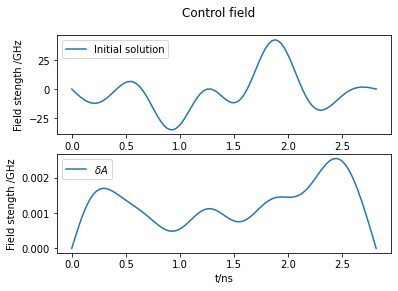

In [42]:
t_list = np.linspace(0,t_f,100)
A_p= vmap(A,in_axes=(0,None,None),out_axes=0)
A_list = A_p(t_list,p_f,t_f)
A_dw = A_p(t_list, main_vec@res_vec.x, t_f)


fig, ax = plt.subplots(2,1)
ax[0].plot(t_list,A_list.real,label='Initial solution')
ax[0].legend()

ax[1].plot(t_list,A_dw.real,label='$\delta A$')
ax[1].legend()

fig.suptitle('Control field')

ax[0].set_ylabel('Field stength /GHz')
ax[1].set_ylabel('Field stength /GHz')

plt.xlabel('t/ns')
plt.show()